In [1]:
# this version of the notebook compares the intermediate outputs from
# a model that uses them to sum up to the final prediction and one that does not.

# UPDATE: I couldn't figure out how to get the intermidiate outputs when they were not used in the graph

In [2]:
from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.mscalev3
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import tensorboard as tb
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# https://stackoverflow.com/a/59789336/12840171
# this is the way to add custome activations - do not do
# get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
# get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})
# instead to
# otherwise problems with saving and loading
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [5]:
def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

def plot_fft(x, y, model=None, xlim=None, logx=False, logy=False):
    xf, yf = compute_fft(x[:,0], y[:,0])
    
    plt.figure(figsize=(14, 6))
    plt.plot(xf, np.abs(yf), label='total')
    
    if model is not None:
        plt.plot(xf, np.abs(compute_fft(x[:,0], model.predict(x)[:,0]))[1], ls='--', label='model', c='k')
        
    plt.axvline(1, c='k', ls='--')
    plt.axvline(4, c='k', ls='--')
    plt.xlabel("f")
    plt.ylabel("|fft(y)|")
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim(0,10)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')

# models

In [6]:
def get_uncompiled_custom_model(
    input_shape,
    output_shape,
    units,
    activation,
    n_blocks,
    layers_per_block,
    scales=[1],
    scale_activation="relu",
    scale_dimension=0,
    dtype=None,
    skip_connection=False,
    plain_network=False,
    group_norm=False
):
    
    input_layer = tf.keras.Input(shape=(input_shape,))

    outputs = [None] * len(scales)

    for i, scale in enumerate(scales):
        scale_tensor = wispy.mscalev3.make_scale_tensor(
            input_shape, scale_dimension, scale, dtype=dtype
        )
        scaled_input = wispy.mscalev3.ScaleLayer(scale_tensor)(input_layer)

        x = tf.keras.layers.Dense(units, activation=scale_activation)(scaled_input)

        if not plain_network:
            outputs[i] = []

        for k in range(n_blocks):
            if skip_connection:
                tmp = x
            for j in range(layers_per_block):
                x = tf.keras.layers.Dense(units, activation=activation)(x)
            if skip_connection:
                x = tf.keras.layers.add([x, tmp])
            if not plain_network:
                outputs[i].append(tf.keras.layers.Dense(output_shape, name=f"outputs_{i}_{k}")(x))
            if group_norm:
                x = tfa.layers.GroupNormalization(groups=1)(x)
        if plain_network:
            outputs[i] = tf.keras.layers.Dense(output_shape, name=f"outputs_{i}")(x)
        else:
            outputs[i] = tf.keras.layers.add([output for output in outputs[i]], name=f"outputs_{i}")

#     if plain_network:
#         outputs = tf.keras.layers.Dense(output_shape)(x) 
#     else:
    if len(outputs) > 1:
        outputs = tf.keras.layers.add([output for output in outputs])
    else:
        outputs = outputs[0]

    model = tf.keras.models.Model(inputs=input_layer, outputs=outputs)

    return model

def get_compiled_custom_model(model_params_dict, lr, loss='mse'):
    model = get_uncompiled_custom_model(**model_params_dict)

    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss=loss, optimizer=optimizer)

    return model

# load data

In [7]:
X_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_train.npy')[:1119]
y_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_train.npy')[:1119]

X_train_raw = np.float32(X_train_raw)
y_train_raw = np.float32(y_train_raw)

# X_train_raw = X_train_raw[:,0].reshape(-1, 1)
X_train_raw = X_train_raw[:,:2].reshape(-1, 2)

# X_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_val.npy')[:1119]
# y_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_val.npy')[:1119]

print(f"X_train_raw.shape: {X_train_raw.shape}")
print(f"y_train_raw.shape: {y_train_raw.shape}")
# print(f"X_val.shape: {X_val.shape}")
# print(f"y_val.shape: {y_val.shape}")

# lets just use 1D input - i.e., time-series
X_train = X_train_raw.copy()
y_train = y_train_raw.copy()

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")



# X_train = np.float32(X_train_raw)
# y_train = np.float32(y_train)
# X_val = np.float32(X_val)
# y_val = np.float32(y_val)

X_train_raw.shape: (1119, 2)
y_train_raw.shape: (1119, 1)
X_train.shape: (749, 2)
y_train.shape: (749, 1)
X_val.shape: (370, 2)
y_val.shape: (370, 1)


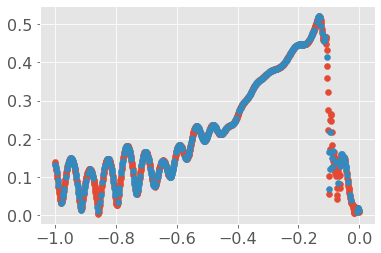

In [8]:
plt.figure()
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_val[:,0], y_val)

# create tf datasets

# base line

In [9]:
# fewer blocks seems like a good rule of thumb because the later blocks are very small

In [167]:
# scales = [1,10,50,100,500]
# scales = [1]
# scales = [1, 10]
# scales = [1,10,50]
# scales = [1,10,50,100]
scales = [10,50,100]
n_scales = len(scales)
n_blocks = 2
layers_per_block = 3

model_params_dict = dict(
    input_shape=2,
    output_shape=1,
    units=256,
    activation='s2relu',
    n_blocks=n_blocks,
    layers_per_block=layers_per_block,
    scales=scales,
    scale_activation="s2relu",
    scale_dimension=0,
    dtype=None,
    skip_connection=False,
    plain_network=False,
    group_norm=False
)

In [168]:
test_model = get_compiled_custom_model(model_params_dict=model_params_dict, lr=1e-3)

In [169]:
callbacks = [
    tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
    wispy.callbacks.ThresholdCallback(1e-6),
    tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.9)
]

In [170]:
%%time
test_history = test_model.fit(x=X_train, y=y_train, epochs=2001, validation_data=(X_val, y_val), verbose=0, batch_size=200, callbacks=callbacks)

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

CPU times: user 2min 15s, sys: 52.3 s, total: 3min 8s
Wall time: 49 s


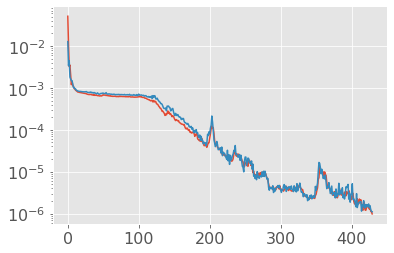

In [171]:
plt.figure()
plt.plot(test_history.history['loss'])
plt.plot(test_history.history['val_loss'])
plt.yscale('log')

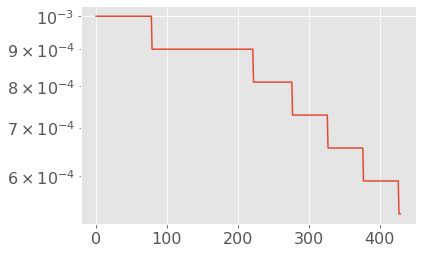

In [172]:
plt.figure()
plt.plot(test_history.history['lr'])
plt.yscale('log')

In [173]:
test_yhat = test_model.predict(X_train)

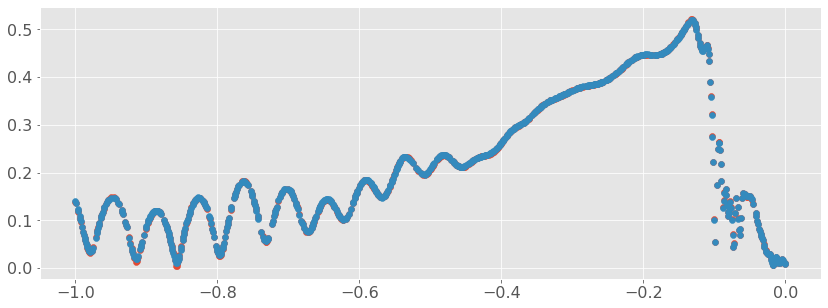

In [174]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], test_yhat)
# plt.xlim(-0.2, 0)

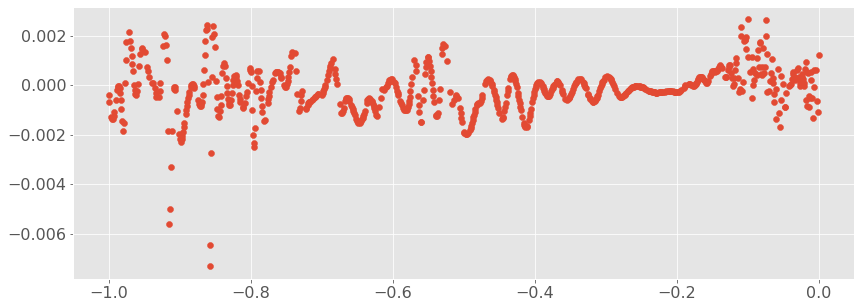

In [175]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train-test_yhat)

(1e-13, 0.001)

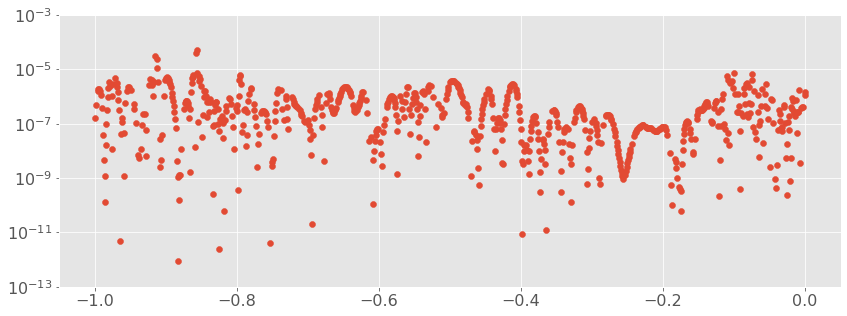

In [176]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], tf.keras.losses.mean_squared_error(y_train,test_yhat))
plt.yscale('log')
plt.ylim(1e-13, 1e-3)

In [177]:
# intermediate outputs

In [178]:
test_model.summary()

Model: "model_175"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
scale_layer_44 (ScaleLayer)     (None, 2)            0           input_12[0][0]                   
__________________________________________________________________________________________________
scale_layer_45 (ScaleLayer)     (None, 2)            0           input_12[0][0]                   
__________________________________________________________________________________________________
scale_layer_46 (ScaleLayer)     (None, 2)            0           input_12[0][0]                   
__________________________________________________________________________________________

In [179]:
n_blocks

2

In [180]:
int_model = {}
layer_names = [f"outputs_{i}" for i in range(n_scales)]
for layer_name in layer_names:
    layer_output = test_model.get_layer(layer_name).output
    int_model[layer_name] = tf.keras.models.Model(test_model.input, outputs=layer_output)

    
for ii in range(n_scales):
    layer_names = [f"outputs_{ii}_{k}" for k in range(n_blocks)]
    for layer_name in layer_names:
        layer_output = test_model.get_layer(layer_name).output
        int_model[layer_name] = tf.keras.models.Model(test_model.input, outputs=layer_output)

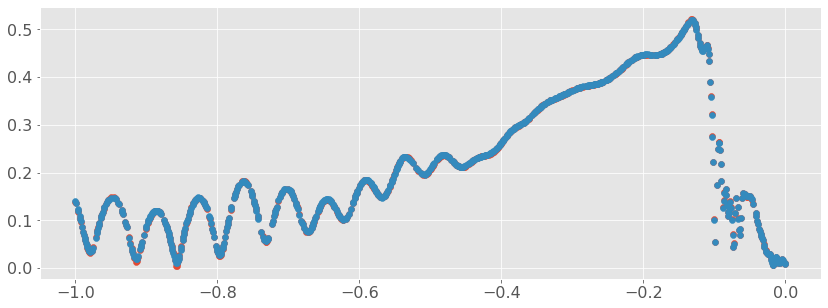

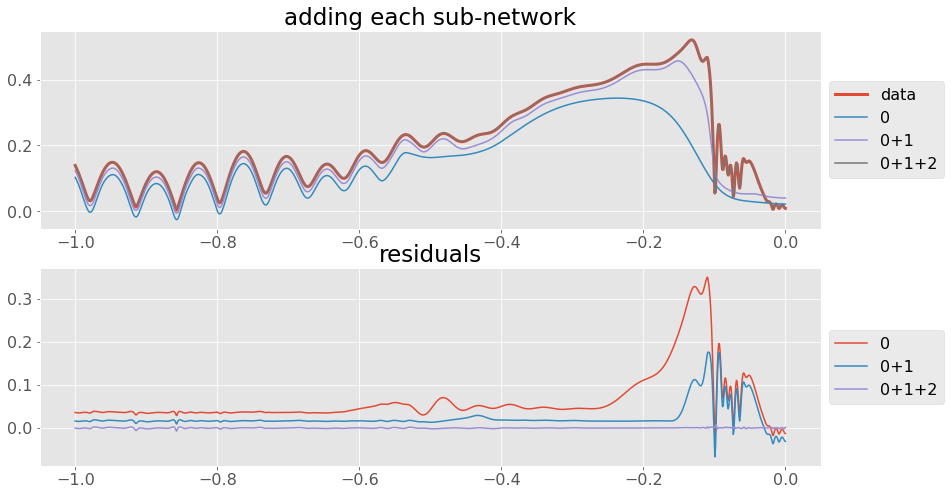

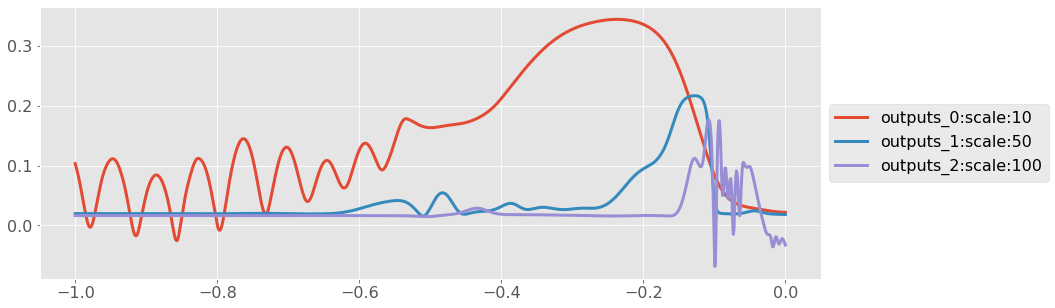

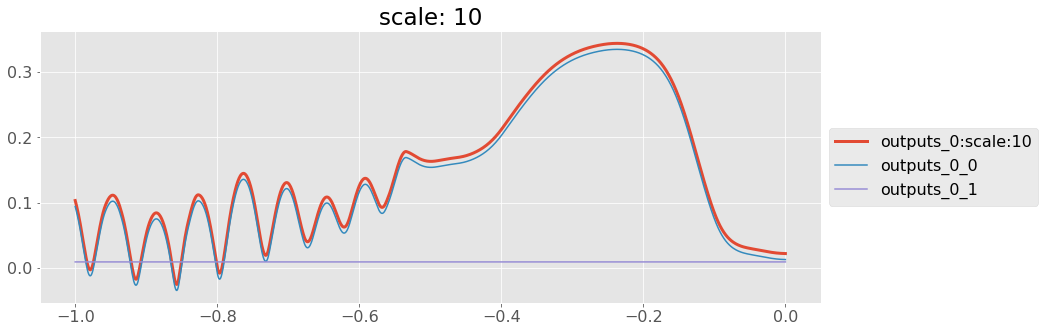

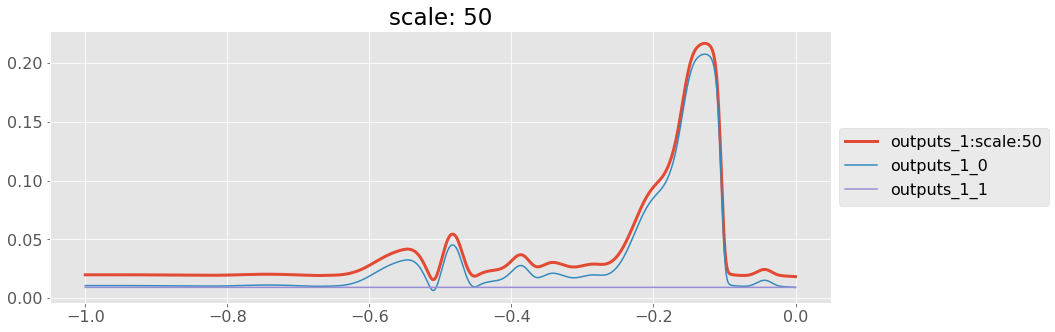

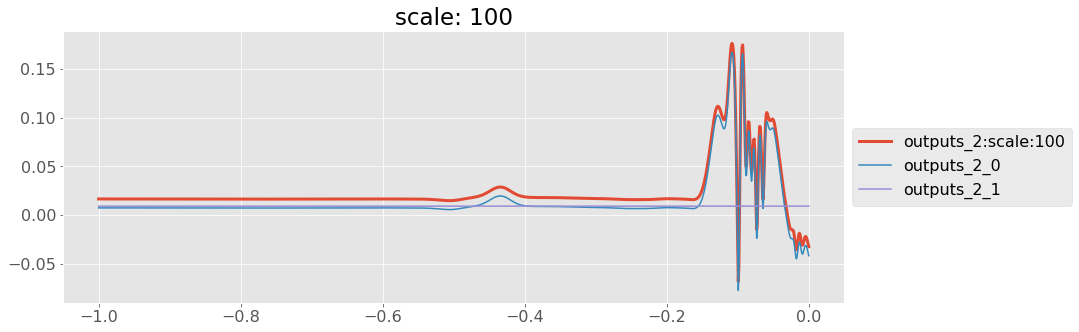

In [181]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train, label='data')
plt.scatter(X_train[:,0], test_yhat)
plt.show()
plt.close()


plt.figure(figsize=(14, 8))
plt.subplot(2,1,1)
plt.plot(X_train_raw[:,0], y_train_raw, label='data', lw=3)
for i in range(1, n_scales+1):
    yy = np.sum([int_model[f"outputs_{ii}"].predict(X_train_raw) for ii in range(i)], axis=0)
    plt.plot(X_train_raw[:,0], yy[:,0], label="+".join([f"{ii}" for ii in range(i)]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('adding each sub-network')

plt.subplot(2,1,2)
for i in range(1, n_scales+1):
    yy = np.sum([int_model[f"outputs_{ii}"].predict(X_train_raw) for ii in range(i)], axis=0)
    plt.plot(X_train_raw[:,0], y_train_raw[:,0]-yy[:,0], label="+".join([f"{ii}" for ii in range(i)]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('residuals')
plt.show()
plt.close()



plt.figure(figsize=(14, 5))
for i in range(n_scales):
    plt.plot(X_train_raw[:,0], int_model[f"outputs_{i}"].predict(X_train_raw), label=f"outputs_{i}:scale:{scales[i]}", lw=3)    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# int_summed = int_model["outputs_0"].predict(X_train_raw) + int_model["outputs_1"].predict(X_train_raw) + int_model["outputs_2"].predict(X_train_raw)
# plt.plot(X_train_raw[:,0], int_summed)

for ii in range(n_scales):
    plt.figure(figsize=(14, 5))
    plt.plot(X_train_raw[:,0], int_model[f"outputs_{ii}"].predict(X_train_raw), label=f"outputs_{ii}:scale:{scales[ii]}", lw=3)  
    for k in range(n_blocks):
        plt.plot(X_train_raw[:,0], int_model[f"outputs_{ii}_{k}"].predict(X_train_raw), label=f"outputs_{ii}_{k}")
    plt.title(f"scale: {scales[ii]}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.close()